# Construction of the network

In [1]:
import csv
import pandas as pd
from collections import Counter
from itertools import permutations
from itertools import combinations
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import networkx as nx

In [2]:
file_movies = 'title.basics.tsv/title.basics.tsv'
movies = pd.read_csv(file_movies, sep='\t', na_values='\\N', dtype={
    'tconst': 'str',
    'titleType': 'str',
    'primaryTitle': 'str',
    'startYear': 'Int64',
}, usecols=['tconst', 'titleType', 'primaryTitle', 'startYear']).set_index('tconst')

In [3]:
movies = movies[(movies['startYear'] >= 1973) & (movies['titleType'] == 'movie')] 
del movies['titleType']

In [4]:
file_cast = 'title.principals.tsv/title.principal.tsv'
cast = pd.read_csv(file_cast, sep='\t', na_values='\\N', dtype={
    'tconst': 'str',
    'nconst': 'str',
    'category': 'str',
}, usecols=['tconst', 'nconst', 'category'])

In [5]:
cast = cast[cast.category.isin({'actor', 'actress'}) & cast['tconst'].isin(movies.index)]
cast.reset_index(drop=True, inplace=True)

In [6]:
file_name='name.basics.tsv/name.basics.tsv'
name = pd.read_csv(file_name, sep='\t', na_values='\\N', dtype={
    'nconst': 'str',
    'primaryName': 'str',
    'birthYear': 'Int64'
}, usecols=['nconst', 'primaryName', 'birthYear']).set_index('nconst')

In [7]:
def get_name_actor(actor_id):
    name_actor=name.loc[actor_id]['primaryName']
    return name_actor

Creation of the network

In [8]:
#we create a bipartite network:
B = nx.Graph()

actors = cast['nconst'].unique()
movies = movies.index.unique()

B.add_nodes_from(actors, bipartite=0)  # Actors belong to set 0
B.add_nodes_from(movies, bipartite=1)  # Movies belong to set 1


for _, row in cast.iterrows():
    actor = row['nconst']
    movie = row['tconst']
    B.add_edge(actor, movie)

In [9]:
print("Number of Actors:", len(actors))
print("Number of Movies:", len(movies))

Number of Actors: 592160
Number of Movies: 426294


In [10]:
B.number_of_edges()

1352739

In [11]:
proj_actors= bipartite.projected_graph(B, actors)

In [12]:
nx.is_connected(proj_actors)

False

In [13]:
conn_comp=[len(c) for c in sorted(nx.connected_components(proj_actors), key=len, reverse=True)]

In [14]:
largest_cc = max(nx.connected_components(proj_actors), key=len)

In [15]:
A = proj_actors.subgraph(largest_cc)

In [16]:
A.number_of_nodes()

432920

In [17]:
A.number_of_edges()

2103908

# Centrality measures

In [18]:
import time
start = time.time()
D = nx.degree_centrality(A)
end = time.time()
print("Time taken =", end-start, "seconds")

Time taken = 4.493644952774048 seconds


In [19]:
sorted_nodes = sorted(D.items(), key=lambda x: x[1], reverse=True)
for i in range(10): 
    actor_id, centrality = sorted_nodes[i]
    name_actor=get_name_actor(actor_id)
    print(name_actor,'with degree',centrality)

Brahmanandam with degree 0.0021643771698631846
Eric Roberts with degree 0.002016543510448837
Ron Jeremy with degree 0.0017947930213273152
Shakti Kapoor with degree 0.0015314643154955084
Mithun Chakraborty with degree 0.0014852662969285248
Mohan Joshi with degree 0.0014228989718630969
Raza Murad with degree 0.0013974900616512559
Nassar with degree 0.001325883132872431
Kiran Kumar with degree 0.0013166435291590345
Avinash with degree 0.0013097138263739867


In [20]:
start = time.time()
BC = nx.betweenness_centrality(A, k=1000) 
end = time.time()

In [21]:
btw_sorted= sorted(BC.items(), key=lambda item: item[1], reverse=True)
for i in range(10): 
    actor_id, btw_centrality = btw_sorted[i]
    name_actor=get_name_actor(actor_id)
    print(name_actor,'with betweenness centrality',btw_centrality)

Eric Roberts with betweenness centrality 0.05876902340504162
Michael Madsen with betweenness centrality 0.025280495898382733
Tom Sizemore with betweenness centrality 0.017463781915745057
Gulshan Grover with betweenness centrality 0.0172929569775084
Ron Jeremy with betweenness centrality 0.014297400140226941
John Savage with betweenness centrality 0.013227693594400288
Anupam Kher with betweenness centrality 0.012431442126895304
Om Puri with betweenness centrality 0.010341560677894301
Franco Nero with betweenness centrality 0.010293940551445816
Udo Kier with betweenness centrality 0.009417537932448324


In [22]:
V = [btw_sorted[i][0] for i in range(len(btw_sorted))]
clos_centr = {}
start = time.time()
for i in range(1000):
    clos_centr[V[i]] = nx.closeness_centrality(A, V[i])
end = time.time()
print("Time taken =", end-start, "seconds")
cc_sorted = sorted(clos_centr.items(), key=lambda item: item[1], reverse=True)

Time taken = 26490.03903388977 seconds


In [23]:
for i in range(10): 
    actor_id, clos_centrality = cc_sorted[i]
    #actor_name = get_name(actor_id)
    name_actor=get_name_actor(actor_id)
    print(name_actor,'with closeness centrality',clos_centrality)

Eric Roberts with closeness centrality 0.2445255288924536
Michael Madsen with closeness centrality 0.2404512442486409
John Savage with closeness centrality 0.23666294203570398
Tom Sizemore with closeness centrality 0.23362636532400813
Harvey Keitel with closeness centrality 0.2318421079408194
David Carradine with closeness centrality 0.2317878631799535
Franco Nero with closeness centrality 0.23161772180342516
Armand Assante with closeness centrality 0.23089025647480346
Malcolm McDowell with closeness centrality 0.22985022960122284
Willem Dafoe with closeness centrality 0.22970656261258657


# Community structure

Clustering coefficient

In [47]:
clus_coeff=nx.clustering(A)

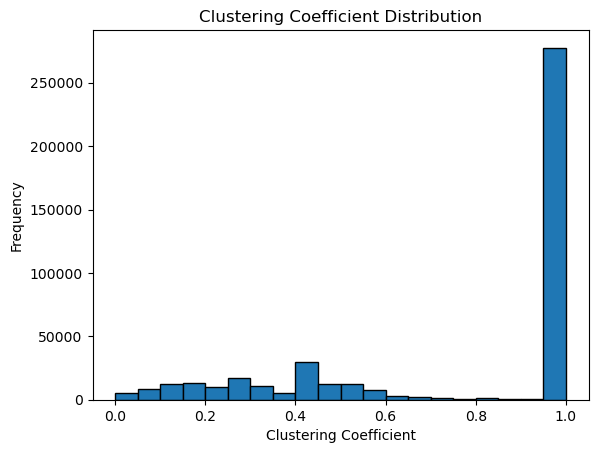

In [48]:
plt.hist(list(clus_coeff.values()), bins=20, edgecolor='k')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.title('Clustering Coefficient Distribution')
plt.show()

In [49]:
nx.average_clustering(A)

0.7626961529179176

# Community detection

In [26]:
start = time.time()
louvain_communities=nx.community.louvain_communities(A)
end = time.time()
print("Time taken =", end-start, "seconds")

Time taken = 298.08148097991943 seconds


In [51]:
# Count how many communities have each size
community_sizes_l = [len(community) for community in louvain_communities]

Text(0.5, 1.0, 'Histogram of Louvain Communities')

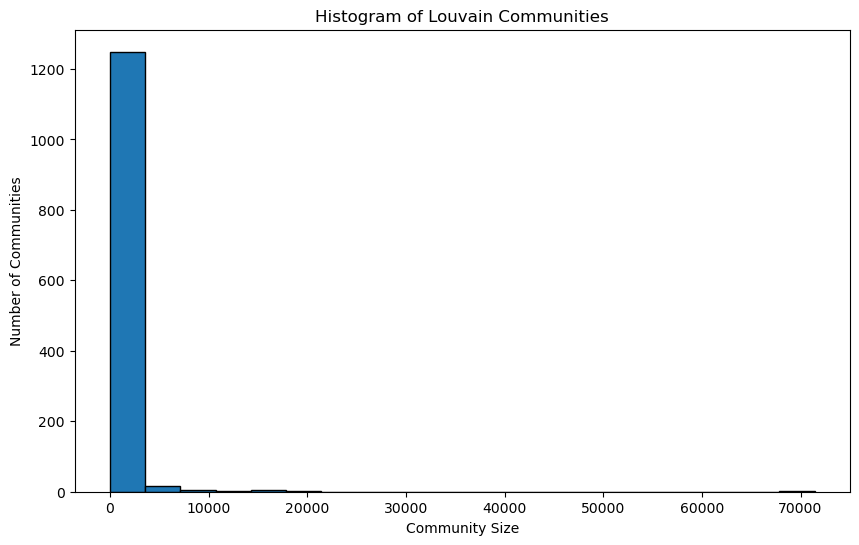

In [52]:
plt.figure(figsize=(10, 6))
plt.hist(community_sizes_l, bins=20, edgecolor='black')  # You can adjust the number of bins as needed
plt.xlabel('Community Size')
plt.ylabel('Number of Communities')
plt.title('Histogram of Louvain Communities')

In [43]:
print(len(community_sizes_l))

1279


# Assortativity

In [30]:
node_degrees = dict(A.degree())
average_degree_connectivity = nx.average_degree_connectivity(A)

degrees = list(node_degrees.values())
avg_deg_connectivity = [average_degree_connectivity[deg] for deg in degrees]

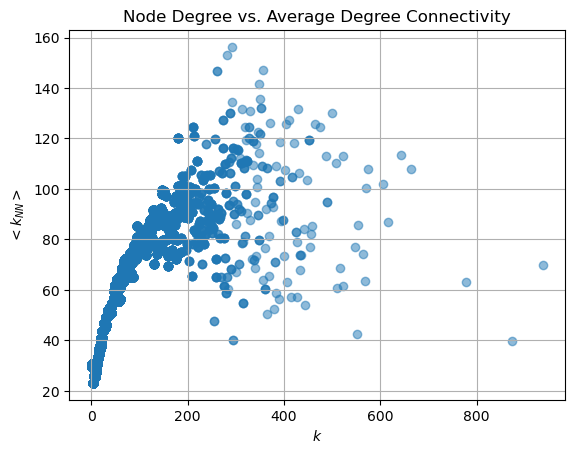

In [37]:
plt.scatter(degrees, avg_deg_connectivity, alpha=0.5)
plt.xlabel("$k$")
plt.ylabel("$<k_{NN}>$") 
plt.title("Node Degree vs. Average Degree Connectivity")
plt.grid(True)
plt.show()

In [38]:
nx.degree_assortativity_coefficient(A)

0.24671357730456878